* Load the **houseprices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.


* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt



# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# houseprices.columns
# print(houseprices.info())
# pd.set_option('display.max_columns', None)
# houseprices.head(10)

In [118]:
houseprices["lotfrontage"].fillna(houseprices["lotfrontage"].mean(), inplace=True)
houseprices["masvnrarea"].fillna(houseprices["masvnrarea"].mean(), inplace=True)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["kitchenqual"])], axis=1)
houseprices['garage_cars_area'] = houseprices['garagecars'] + houseprices['garagearea']
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["fence"])], axis=1)
houseprices['baths'] = houseprices.fullbath * houseprices.halfbath # 0.395
houseprices['sold_remodeled'] = houseprices.yearbuilt * houseprices.yearremodadd # 0.577
houseprices['sold_garage'] = houseprices.yearbuilt * houseprices.garageyrblt # 0.522
houseprices['bsm_first_sf'] = houseprices.totalbsmtsf * houseprices.firstflrsf # 0.54
houseprices['grade_living_area'] = houseprices.totrmsabvgrd  * houseprices.grlivarea # 0.648
houseprices['basement'] = houseprices.bsmtfullbath  * houseprices.bsmtfinsf1 # 0.346

# houseprices.corr()

* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.

The model is a good fit for the training set with R-squared/adjusted values greater than 0.76. 



In [119]:

features = houseprices[['overallqual', 'totalbsmtsf', 'grade_living_area', 'garage_cars_area', 'TA', 'sold_remodeled']]
target = houseprices[['saleprice']]

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(features_train.shape[0]))
print("The number of observations in test set is {}".format(features_test.shape[0]))

features_train = sm.add_constant(features_train)

# We fit an OLS model using statsmodels
results = sm.OLS(target_train, features_train).fit()

# We print the summary results
print(results.summary())


The number of observations in training set is 1168
The number of observations in test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     630.2
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:00:35   Log-Likelihood:                -13980.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1161   BIC:                         2.801e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?

Yes and no - the model fits the lower values of the target really well but strays quite a bit from the higher values. The performance metrics are all very large with the exception of the MAPE. Why is this? My plot seems to fit the datapoints better than the example in the module, whose evaluation metrics are much lower, other than the MAPE.

Additionally, the code for the metrics in the module didn't work for me and I'm not sure why. The MSE, RMSE, and MAPE kept printing as arrays, with MAPE printing an array of nans. I received assistance from Technical Coaching for the MAPE metric and from my mentor for the other two, but why did the code not work for my data?



In [120]:
# print(target_test.shape)
# target_preds.shape

# mse(target_test, target_preds)

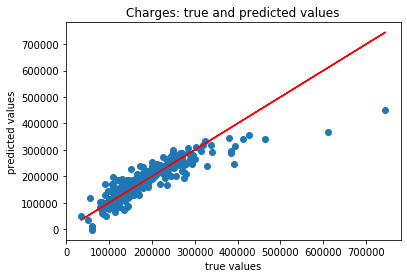

Mean absolute error of the prediction is: 25281.842280486766
Mean squared error of the prediction is: 1512466667.9751637
Root mean squared error of the prediction is: 38890.44443015744
Mean absolute percentage error of the prediction is: 15.023300987638367


In [121]:
features_test = sm.add_constant(features_test)

# We are making predictions here
target_preds = results.predict(features_test)


plt.scatter(target_test, target_preds)
plt.plot(target_test, target_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target_test, target_preds)))
# print("Mean squared error of the prediction is: {}".format(mse(target_test, target_preds, axis=1)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target_test, target_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(target_test, target_preds))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target_test['saleprice'] - target_preds)/target_test['saleprice']) * 100)))
# print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target_test - target_preds) / target_test)) * 100))

In [122]:
target_test.isnull()
target_test.isnull().values.any()

False

* Try to improve your model in terms of predictive performance by adding or removing some variables.

I'm going to remove total basement square feet and add full bath.  This new model is worse - the R-squared/adjusted values are lower and all of the evaluation metrics are higher. However, adding the total basement square feet back into the model brings the metrics lower than the original model. 

I've been having a problem with multicollinearity, so I removed overall quality as this feature is positively correlated with most of the other feature. This did not help - the R-squared/adjusted values decreased, the AIC and BIC values increased as did the majority of our prediction metrics. The only measurement that improved was the MAPE, but I don't imagine this makes up for the decrease in quality of the model.

In [126]:
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["lotconfig"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["condition1"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["condition2"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["roofstyle"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["exterior1st"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["heating"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["electrical"])], axis=1)

# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["mszoning"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["street"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["landcontour"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["landslope"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["housestyle"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["heating"])], axis=1)
# houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["exterqual"])], axis=1)

houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["paveddrive"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["poolqc"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["saletype"])], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["salecondition"])], axis=1)

# pd.set_option('display.max_columns', None)
# houseprices.corr()

The number of observations in training set is 1168
The number of observations in test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     587.0
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:04:16   Log-Likelihood:                -14011.
No. Observations:                1168   AIC:                         2.804e+04
Df Residuals:                    1161   BIC:                         2.807e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

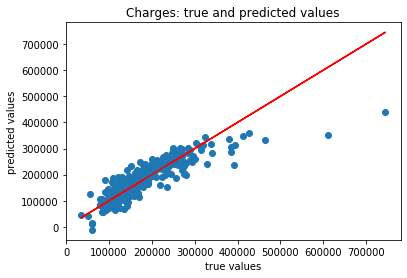

Mean absolute error of the prediction is: 27719.93999706251
Mean squared error of the prediction is: 1720347361.593593
Root mean squared error of the prediction is: 41477.070311120005
Mean absolute percentage error of the prediction is: 16.478824372510935


In [128]:
features = houseprices[['overallqual','grade_living_area', 'garage_cars_area', 'TA', 'sold_remodeled', 'fullbath']]
target = houseprices[['saleprice']]

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(features_train.shape[0]))
print("The number of observations in test set is {}".format(features_test.shape[0]))

features_train = sm.add_constant(features_train)

# We fit an OLS model using statsmodels
results = sm.OLS(target_train, features_train).fit()

# We print the summary results
print(results.summary())

features_test = sm.add_constant(features_test)

# We are making predictions here
target_preds = results.predict(features_test)

plt.scatter(target_test, target_preds)
plt.plot(target_test, target_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target_test, target_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target_test, target_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(target_test, target_preds))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target_test['saleprice'] - target_preds)/target_test['saleprice']) * 100)))



The number of observations in training set is 1168
The number of observations in test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     539.9
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:06:14   Log-Likelihood:                -13979.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1160   BIC:                         2.802e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

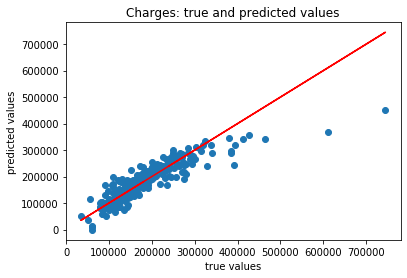

Mean absolute error of the prediction is: 25262.778083118355
Mean squared error of the prediction is: 1507740649.5486124
Root mean squared error of the prediction is: 38829.636227353614
Mean absolute percentage error of the prediction is: 15.01381270301065


In [129]:
features = houseprices[['overallqual','totalbsmtsf','grade_living_area', 'garage_cars_area', 'TA', 'sold_remodeled', 'fullbath']]
target = houseprices[['saleprice']]

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(features_train.shape[0]))
print("The number of observations in test set is {}".format(features_test.shape[0]))

features_train = sm.add_constant(features_train)

# We fit an OLS model using statsmodels
results = sm.OLS(target_train, features_train).fit()

# We print the summary results
print(results.summary())

features_test = sm.add_constant(features_test)

# We are making predictions here
target_preds = results.predict(features_test)

plt.scatter(target_test, target_preds)
plt.plot(target_test, target_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target_test, target_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target_test, target_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(target_test, target_preds))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target_test['saleprice'] - target_preds)/target_test['saleprice']) * 100)))



In [139]:
houseprices[['overallqual', 'totalbsmtsf', 'grade_living_area', 'garage_cars_area', 'TA', 'sold_remodeled']].corr()

,overallqual,totalbsmtsf,grade_living_area,garage_cars_area,TA,sold_remodeled
overallqual,1.000,0.538,0.514,0.562,-0.554,0.630
totalbsmtsf,0.538,1.000,0.401,0.487,-0.311,0.392
grade_living_area,0.514,0.401,1.000,0.413,-0.287,0.195
garage_cars_area,0.562,0.487,0.413,1.000,-0.371,0.487
TA,-0.554,-0.311,-0.287,-0.371,1.000,-0.567
sold_remodeled,0.630,0.392,0.195,0.487,-0.567,1.000


The number of observations in training set is 1168
The number of observations in test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     477.1
Date:                Fri, 01 Nov 2019   Prob (F-statistic):          3.95e-309
Time:                        19:14:29   Log-Likelihood:                -14100.
No. Observations:                1168   AIC:                         2.821e+04
Df Residuals:                    1161   BIC:                         2.825e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

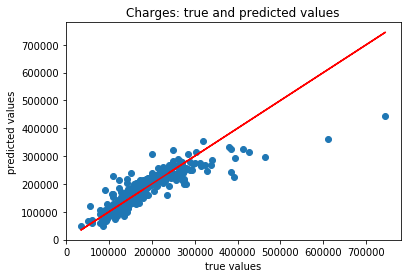

Mean absolute error of the prediction is: 25868.317526857565
Mean squared error of the prediction is: 1718051546.4801052
Root mean squared error of the prediction is: 41449.38535708467
Mean absolute percentage error of the prediction is: 14.375431450057828


In [140]:
features = houseprices[['totalbsmtsf','grade_living_area', 'garage_cars_area', 'TA', 'sold_remodeled', 'fullbath']]
target = houseprices[['saleprice']]

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(features_train.shape[0]))
print("The number of observations in test set is {}".format(features_test.shape[0]))

features_train = sm.add_constant(features_train)

# We fit an OLS model using statsmodels
results = sm.OLS(target_train, features_train).fit()

# We print the summary results
print(results.summary())

features_test = sm.add_constant(features_test)

# We are making predictions here
target_preds = results.predict(features_test)

plt.scatter(target_test, target_preds)
plt.plot(target_test, target_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(target_test, target_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(target_test, target_preds)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(target_test, target_preds))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((target_test['saleprice'] - target_preds)/target_test['saleprice']) * 100)))
